# CHALLENGE 3: Tuned Bidirectionl LSTM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2]:
# Reuseable visualizatoin function
def visualize_plot(x, y=None, x_label='', y_label='', title='', labels=None, markers=None, legend=True, grid=True, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    if y is not None:
        if isinstance(x, list) and isinstance(y, list) and len(x) == len(y):  # Multiple series
            for i in range(len(y)):
                plt.plot(x[i], y[i], label=labels[i] if labels else None, marker=markers[i] if markers else None)
        else:  # Single series
            plt.plot(x, y, label=labels[0] if labels else None, marker=markers[0] if markers else None)
    else:  # Plot only x if y is None
        plt.plot(x)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if legend and labels:
        plt.legend()
    if grid:
        plt.grid(True)
    plt.show()


# Helper function to prepare windowed datasets
def windowed_dataset(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # Split into input (x) and target (y)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(1) # Shuffle, batch, and prefetch
    return dataset

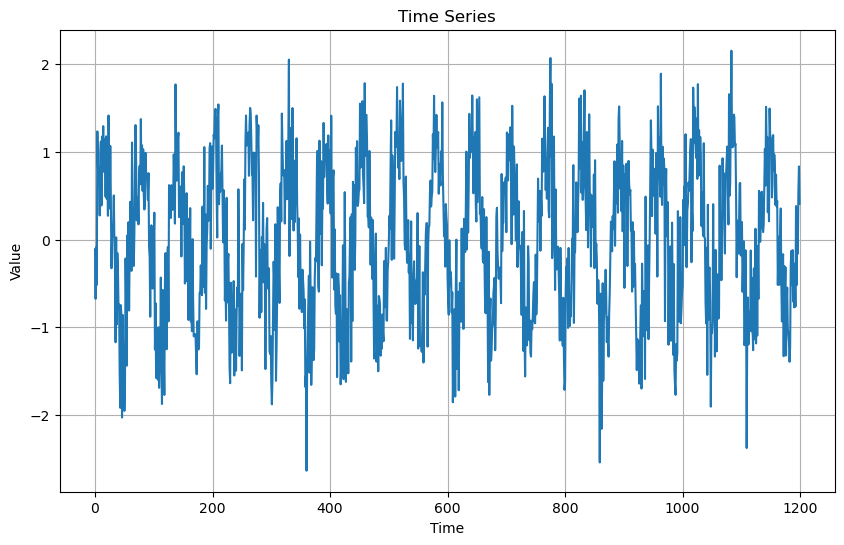

In [3]:
# Create synthetic time series data
def generate_time_series():
    time = np.arange(1200)  # Total of 1200 time steps
    series = np.sin(0.1 * time) + np.random.normal(scale=0.5, size=1200)  # Sine wave with added noise
    return time, series

time, series = generate_time_series()

# Plot the synthetic data
visualize_plot(
    time, series,
    x_label='Time', y_label='Value',
    title = 'Time Series',
    grid=True
)

In [4]:
# Split the data into training and validation sets
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

# Window size and batch size
window_size = 20
batch_size = 32

# Create windowed datasets for both training and validation
train_dataset = windowed_dataset(x_train, window_size, batch_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size)

In [12]:
# Window size and batch size
window_size = 20
batch_size = 32

# Create windowed datasets for both training and validation
train_dataset = windowed_dataset(x_train, window_size, batch_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size)

# Build the Bidirectional LSTM model using Functional API
inputs = layers.Input(shape=[None], name='Input_Layer')
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), name='Expand_dims')(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True), name='Bidirectional_LSTM_1')(x)
x = layers.Bidirectional(layers.LSTM(32), name='Bidirectional_LSTM_2')(x)
x = layers.Dense(1, name='Dense_Layer')(x)
outputs = layers.Lambda(lambda x: x * 100, name='Scaling_output')(x)


# Create the model
model_tune = Model(inputs=inputs, outputs=outputs, name='Model_Tune')


# Compile the model

model_tune.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
    metrics=['mse']
)

model_tune.summary()


# Train the model
history = model_tune.fit(
    train_dataset.repeat(),
    epochs=100,
    validation_data=valid_dataset.repeat(),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_valid) // batch_size
)




Model: "Model_Tune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Expand_dims (Lambda)            │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_LSTM_1            │ (None, None, 64)       │         8,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_LSTM_2            │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Scaling_output (Lambda)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5040 - mse: 1.2358 - val_loss: 0.4607 - val_mse: 1.1292
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4746 - mse: 1.1615 - val_loss: 0.4386 - val_mse: 1.0792
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4440 - mse: 1.0425 - val_loss: 0.4305 - val_mse: 1.0529
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4492 - mse: 1.0664 - val_loss: 0.4281 - val_mse: 1.0547
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4638 - mse: 1.1180 - val_loss: 0.4160 - val_mse: 1.0094
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4075 - mse: 0.9635 - val_loss: 0.4077 - val_mse: 0.9808
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4095 - mse: 0.9658 - val_loss: 0.4006 - val_mse: 0.9608
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4026 - mse: 0.9455 - val_loss: 0.3956 - val_mse: 0.9466
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2281 - mse: 0.4791 - val_loss: 0.2388 - val_mse: 0.5189
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2418 - mse: 0.5099 - val_loss: 0.2317 - val_mse: 0.5018
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2228 - mse: 0.4689 - val_loss: 0.2290 - val_mse: 0.4955
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2407 - mse: 0.5061 - val_loss: 0.2287 - val_mse: 0.4943
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2215 - mse: 0.4626 - val_loss: 0.2246 - val_mse: 0.4853
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2214 - mse: 0.4635 - val_loss: 0.2229 - val_mse: 0.4812
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2373 - mse: 0.5001 - val_loss: 0.2217 - val_mse: 0.4780
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2414 - mse: 0.5087 - val_loss: 0.2202 - val_mse: 0.4747
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2024-11-29 11:49:18.564670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


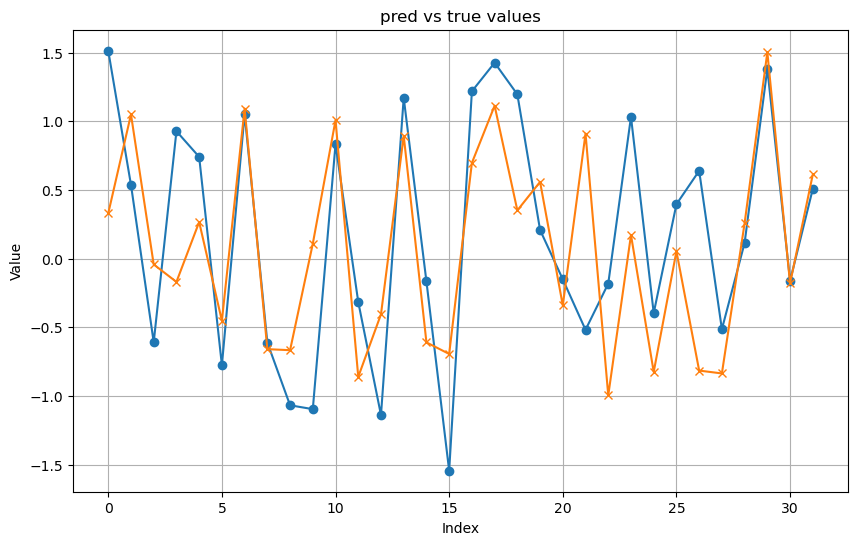

In [13]:
# Make predictions
predictions = []
true_values = []
for input_batch, target_batch in valid_dataset.take(1):
    predictions = model_tune.predict(input_batch).flatten()
    true_values = target_batch.numpy().flatten()

# Visualize predictions vs. true values
visualize_plot(
    [range(len(true_values)), range(len(predictions))],
    [true_values, predictions],
    x_label='Index', y_label='Value',
    title='pred vs true values',
    markers=['o','x']
)